# 9. Nenadzorovano strojno učenje - Gručenje

(pripravil Gorjan Nadzinski, FEEIT, CMUS, Makedonija)

V tem poglavju boste spoznali nenadzorovano strojno učenje kot metodo učenja iz podatkov, ki so "neoznačeni", tj. imajo samo znane lastnosti, ne poznajo pa vrednosti ali razreda (glej sliko 1). Splošna ideja je, da bi algoritem lahko razvrstil podatke na podlagi nekaterih skritih vzorcev. 

<figure>
<img src="unsup1.png" style="height: 300px;"/> 
<figcaption align = "center"> Slika 1 </figcaption>
</figure>

Gručenje je oblika nenadzorovanega učenja, pri kateri je naloga algoritma, da množico predmetov razvrsti v skupine, imenovane **gruče**, tako da so si predmeti v isti gruči bolj podobni kot predmeti v drugih gručah. 

Obstaja več različnih algoritmov gručenja, kot so:

* KMeans;
* DBSCAN;
* Aglomerativno hierarhično grozdenje;
* Gručenje z maksimizacijo pričakovanja (EM);
* Gručenje s srednjim premikom. 

Zelo pogosto je od uporabnika odvisno, da določi število gruč, ki je najpomembnejši hiperparameter pri gručenju. Različni algoritmi nato uporabijo različne metode za razvrščanje podatkov v gruče (npr. razdalja med podatkovnimi točkami, gostota podatkovnih točk, itd.).

## 9.1. KMeans gručenje

### 9.1.1. Algoritem

To je ena najbolj priljubljenih in pogosto uporabljenih metod za združevanje v gručenje. Podatke razdeli v K različnih grozdov na podlagi evklidske (geometrijske) razdalje med podatkovnimi točkami. 

Gre za preprost algoritem, ki deluje na naslednji način:
1. Naključno generiranje središčnih točk (imenovanih **centroidi**) K gruč.
2. Preglejte vse podatkovne točke in preverite, kateri centroid je najbližji; podatkovno točko pripišite tej gruči.
3. Izračunajte novo lokacijo za vsakega od K centroidov tako, da izračunate povprečje lokacij vseh podatkovnih točk, ki so bile dodeljene tej gruči.
4. Izračunajte vrednost **stroškovne funkcije** za dano gručenje. 
5. Če je razlika med vrednostmi stroškovne funkcije v trenutni in prejšnji iteraciji večja od tolerance $\epsilon$, se vrnite na korak 2. V nasprotnem primeru vrnite zadnje gručenje.  
ALI  
Če največje število iteracij ni bilo doseženo, se vrnite na korak 2. V nasprotnem primeru vrnite zadnje gručenje. 

Zadnji korak se razlikuje glede na to, ali je pogoj za ustavitev algoritma doseganje določenega največjega števila iteracij ali pa je pogoj, da vrednost stroškovne funkcije konvergira (tj. da se med iteracijami preneha bistveno spreminjati). Prag $\epsilon$, pod katerim se sprememba šteje za nepomembno, je prav tako hiperparameter, ki ga določi uporabnik. 

Algoritem je vizualno prikazan na sliki 2, kjer je prikazana porazporeditev podatkovnih točk v 3 gruče v 14 iteracijah. 

<figure>
<img src="K-means_convergence.gif" style="height: 300px;"/>
<figcaption align = "center"> Slika 2 (Chire, CC BY-SA 4.0 <https://creativecommons.org/licenses/by-sa/4.0>, via Wikimedia Commons) </figcaption>
</figure>

Stroškovna funkcija

Stroškovna funkcija v metodi KMeans se imenuje tudi **izkrivljanje** in je vsota razdalj med vsako točko in njenim lokalnim centroidom.

Če je _m_ število podatkovnih točk, _x<sup>(i)</sup>_ so podatkovne točke, _$\mu$<sub>(i)</sub>_ je centroid gruče, kateri je bila točka _x<sup>(i)</sup>_ dodeljena in $||A-B||^2$ je razdalja med točkama A in B, potem je izkrivljanje, ki jo označimo z _J_, izračunana kot:

$J=\frac{1}{m}\sum_{i=1}^m ||x^{(i)}-\mu_{(i)}||^2$

S korakoma 2 in 3 poskuša algoritem dejansko optimizirati to funkcijo _J_. Poskuša najti najboljšo možno porazdelitev podatkovnih točk v gruče, ki bo povzročila najmanjšo možno vrednost za _J_.

Ta stroškovna funkcija ni konveksna, kar pomeni, da če algoritem KMeans za iste podatke zaženete dvakrat, morda ne boste dobili enakega rezultata. Končni rezultat je odvisen od začetnih lokacij centroidov, ki so izbrani naključno. Zato je zelo pomembno, da algoritem preizkusite večkrat, da mu omogočite pravilno konvergenco in izberete najboljši rezultat. 

Druga možnost je uporaba posebnega načina izbire začetnih lokacij centroidov, ki se imenuje k-means++. Te metode ne bomo predstavljali, vredno pa si je zapomniti, da je uporabljena, ko kličemo KMeans funkcijo iz knjižnice sklearn.


### 9.1.3. Enostavni primeri

Določimo nekaj primerov zbirk podatkov in na njih preizkusimo algoritem KMeans.

In [2]:
#vključimo vse knjižnice in module
import numpy as np
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

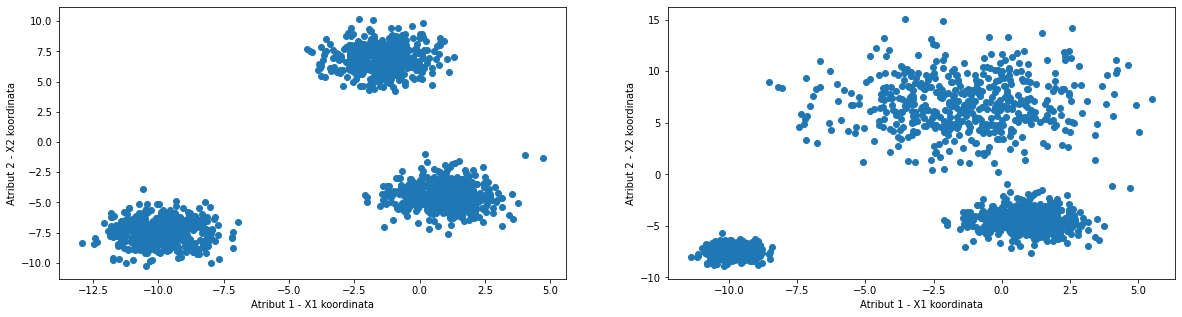

In [3]:
n_samples = 1500 # Število podatkovnih točk
random_state = 100 # Številka za generator naključnih števil
# Generiraj bloke s podobno varianco
blobs = datasets.make_blobs(n_samples=n_samples,random_state=random_state)
# Generiraj bloke z različno varianco
varied = datasets.make_blobs(n_samples=n_samples,cluster_std=[1.0, 2.5, 0.5],random_state=random_state)

# Nariši podatkovne zbirke:
datsets = {'blobs': blobs,'varied': varied}
plot_nr = 1
plt.figure(figsize=(20, 5))
for key in datsets:
    X, y = datsets[key]
    plt.subplot(1, len(datsets), plot_nr)
    plt.scatter(X[:, 0], X[:, 1])
    plt.xlabel('Atribut 1 - X1 koordinata')
    plt.ylabel('Atribut 2 - X2 koordinata')
    plot_nr += 1

Zdi se očitno, da morajo biti v obeh primerih 3 gruče, zato upoštevajmo to število.

Najprej ločimo sode bloke v gruče. Naredimo naslednje:  
* Pridobimo dvodimenzionalne koordinate vsake podatkovne točke (X) in gruče, v katerega spada (y). POMEMBNO: Algoritem ne pozna gruč podatkovnih točk, zato gre za nenadzorovano učenje.
* Atribute standardiziramo s funkcijo StandardScaler, kar pomeni, da imajo zdaj vsi podatki ničelno povprečje in enotno varianco. To je pomemben korak pri gručenje, da se izognemo težavam, ki bi lahko nastale zaradi oblike in porazdelitve podatkov.
* Pokličemo/inicializiramo algoritem KMeans. Dodamo naslednje argumente:
  * _n__clusters_ je število grozdov.
  * _init_ je način inicializacije centroidov. To lahko storimo naključno, kot je navedeno v tem primeru, ali pa uporabimo k-means++, ki izbere začetne centroide gruč z vzorčenjem na podlagi empirične verjetnostne porazdelitve prispevka točk k skupni inerciji.
  * _n__init_ je število poskusov, ko bo algoritem naključno regeneriral začetne centroide, preden bo izbral najboljši primer. 
  * _max__iter_ je število iteracij, preden se algoritem ustavi.
* Algoritem zaženemo s kmeans.fit_predict in fit_transform (opazite, da algoritmu posredujemo samo vrednosti X). 
* Rezultate prikažemo na grafu, kjer je vsaka gruča v drugi barvi.

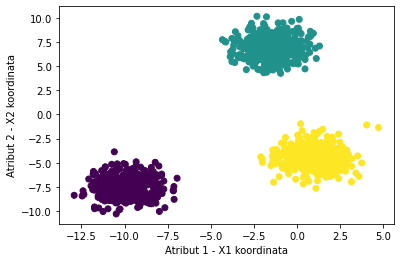

In [4]:
X, y = datsets['blobs'] # pridobi podatke
scaler = StandardScaler() # standardiziraj podatke
kmeans = KMeans(n_clusters=3,init='random',n_init=5,max_iter=20) # inicializiraj algoritem
y_pred = kmeans.fit_predict(scaler.fit_transform(X)) # poženi algoritem
#nariši:
plt.scatter(X[:, 0], X[:, 1], c=y_pred) 
plt.xlabel('Atribut 1 - X1 koordinata')
plt.ylabel('Atribut 2 - X2 koordinata');

Opazite, kako so podatki v skladu z našimi standardi logično razdeljeni v tri sklope. Vprašanje, ki ga bomo obravnavali pozneje, pa je, kako na splošno določiti število gruč, če problema ne moremo vizualizirati. 

Nato preverimo, kaj se zgodi, ko poskušamo podatke raznolike oblike razdeliti v 3 gruče. Uporabimo enake argumente kot prej, le da tokrat določimo, da je število naključnih inicializacij 1. To pomeni, da bo algoritem poskušal podatke ločiti že po 1 poskusu naključne inicializacije centroidov. Nekajkrat zaženite naslednjo kodo in opazite, da razvrščanje v gručenje ni dosledno, saj je odvisno od začetnih pogojev.

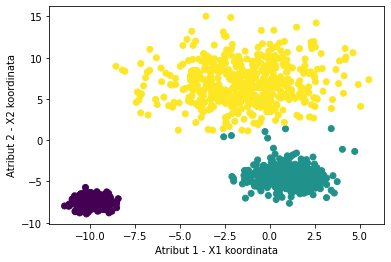

In [6]:
X, y = datsets['varied'] # pridobi podatke
scaler = StandardScaler() # standardiziraj podatke
kmeans = KMeans(n_clusters=3,init='random',n_init=1,max_iter=20) # inicializiraj algoritem
y_pred = kmeans.fit_predict(scaler.fit_transform(X)) # poženi algoritem
# nariši:
plt.scatter(X[:, 0], X[:, 1], c=y_pred) 
plt.xlabel('Atribut 1 - X1 koordinata')
plt.ylabel('Atribut 2 - X2 koordinata');

To je mogoče enostavno odpraviti na več različnih načinov:
* število inicializacij je lahko večje (kot v prejšnjem primeru), 
* število iteracij je lahko večje (čeprav to ne zagotavlja vedno konvergence),
* lahko se uporabi drugačna tehnika inicializacije: k-means++ namesto naključne. 

Ponovno poskusite s primerom, vendar tokrat spremenite vrednosti teh treh argumentov in opazujte rezultate.

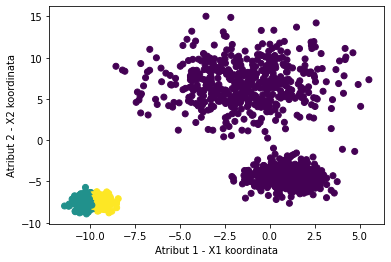

In [8]:
X, y = datsets['varied'] # pridobi podatke
scaler = StandardScaler() # standardiziraj podatke


# poskusi obe metodi. Vstavi 0 za 'random' in 1 za 'k-means' v init parameter 
#pri klicu metode K-means
init=['random','k-means++'] 
# poskusi različno število inicializacij:
n_init=1 
# poskusi različno (večje) število maksimalni inicializacij
max_iter=200 

kmeans = KMeans(n_clusters=3,init=init[0],n_init=n_init,max_iter=max_iter) # inicializiraj algoritem
y_pred = kmeans.fit_predict(scaler.fit_transform(X)) # poženi algoritem
# nariši:
plt.scatter(X[:, 0], X[:, 1], c=y_pred) 
plt.xlabel('Atribut 1 - X1 koordinata')
plt.ylabel('Atribut 2 - X2 koordinata');

Upoštevajte, da pri eni naključni inicializaciji včasih gruče ne konvergirajo pravilno, ne glede na število iteracij.

### 9.1.4. Določanje števila gruč

Če problema ni mogoče preprosto razumeti ali vizualizirati, števila gruč ne moremo vedno preprosto določiti. Dobra metoda za določitev najboljšega števila grozdov je uporaba tako imenovane **"komolčne metode "**. 

Njena ideja je izračunati vrednost popačenja na koncu gruč za različna števila gruč. Ne pozabite, da je ta vrednost prikaz "slabosti" ali napake pri gručenju in mora biti čim nižja. 

Če se popačenje pri določenem številu nenadoma zmanjša, nato pa je zmanjševanje počasnejše in linearno, potem je izbrano to število gruč Razlog je v tem, da število gruč povzroči preveliko popačenje pri manjšem številu gruč, več gruč pa se ne splača, saj se popačenje ne zmanjša več veliko.

To pokažimo na prejšnjih primerih.

C:\Users\ziga\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
C:\Users\ziga\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


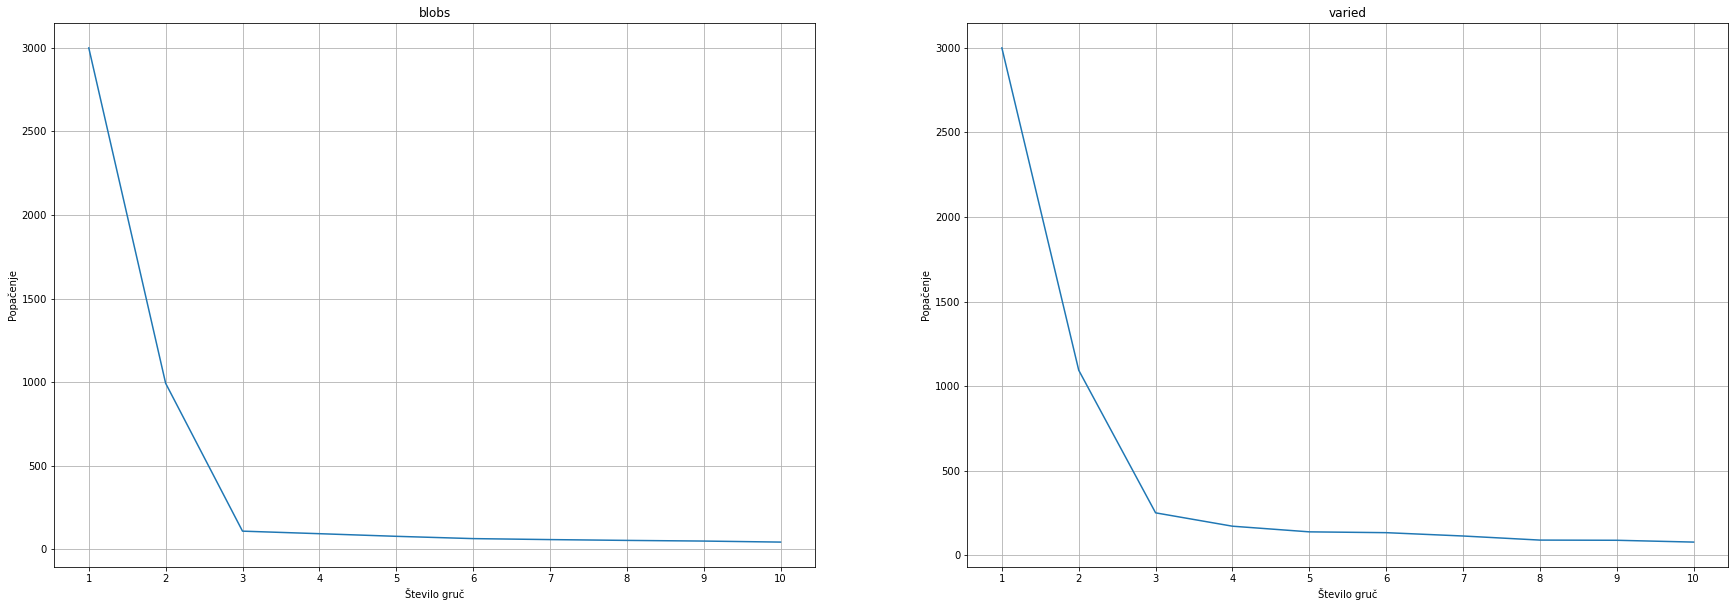

In [9]:
plt.figure(figsize=(30, 10)) # ustvari prazno sliko
plot_nr = 1 # inicializiraj števec za število slik
max_nr_clusters = 10 # maksimalno število gruč

for key in datsets: # za vsako podatkovno zbirko:
    X, y = datsets[key] # pridobi podatke
    cost_func = [] # definiraj prazen list, kjer se bodo shranile vrednosti popačenja
    for nr_clusters in range(1, max_nr_clusters + 1): #povečuj število gruč začenši z 1
        scaler = StandardScaler() # standardiziraj podatke
        kmeans = KMeans(n_clusters=nr_clusters,init='random',n_init=5) # inicializiraj algoritem
        kmeans.fit(scaler.fit_transform(X)) # poženi algoritem
        cost_func.append(kmeans.inertia_) # izračunaj inercijo
    # nariši odvisnost popačenj za različno število gruč
    plt.subplot(1, len(datsets), plot_nr) 
    plt.plot(range(1, 11), cost_func)
    plt.xlabel('Število gruč')
    plt.ylabel('Popačenje')
    plt.title(key)
    plt.xticks(range(1, 11))
    plt.grid()
    plot_nr += 1 

Očitno je, da se komolec (točka preloma) v obeh primerih pojavi za 3 grozde. Zato je bila naša izbira na začetku, ki jo je spodbudil videz podatkov, pravilna. 

Seveda ta metoda služi le kot priporočilo glede števila gruč Vse dodatne informacije o problemu lahko pomagajo pri določanju števila grozdov še bolj kot metoda komolca.

### 9.1.5. Omejitve metode KMeans

KMeans je prepričljiv, ker ga je enostavno izvajati in ga je mogoče uporabljati z velikimi podatkovnimi množicami. Vendar je ena njegovih glavnih pomanjkljivosti (poleg dejstva, da je občutljiv na začetne lokacije centroidov grozdov) ta, da se slabo obnese, kadar imajo podatki nekatere nepravilne (ne kroglaste) oblike. 

Tak primer je razviden iz naslednjih podatkovnih nizov, ki so oblikovani kot koncentrični krogi in kot polmeseci.

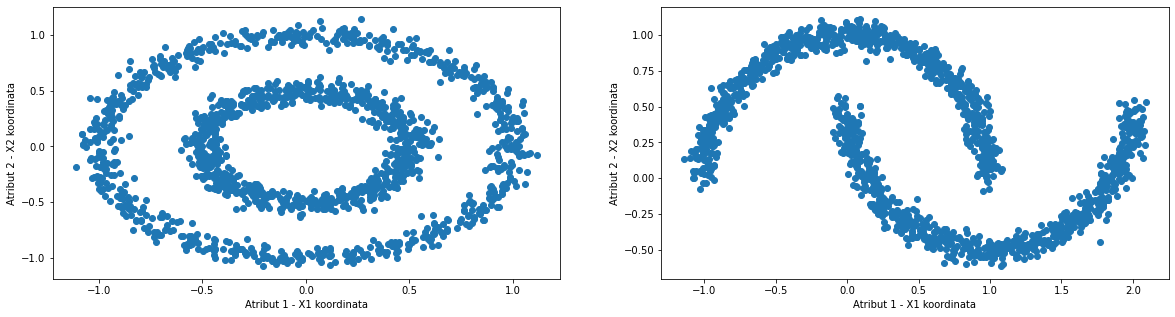

In [10]:
n_samples = 1500 # število podatkovnih točk
random_state = 100 # številka za generator naključnih števil 
# generiraj koncentrične kroge
noisy_circles = datasets.make_circles(n_samples=n_samples,factor=.5,noise=.05)
# generiraj lune
noisy_moons = datasets.make_moons(n_samples=n_samples,noise=.05) 

# nariši podatke
datsets2 = {'circles': noisy_circles,'crescents': noisy_moons}
plot_nr = 1
plt.figure(figsize=(20, 5))
for key in datsets2:
    X, y = datsets2[key]
    plt.subplot(1, len(datsets2), plot_nr)
    plt.scatter(X[:, 0], X[:, 1])
    plt.xlabel('Atribut 1 - X1 koordinata')
    plt.ylabel('Atribut 2 - X2 koordinata')
    plot_nr += 1

Poskusimo podatke razdeliti v dve gruči, pri čemer pričakujemo, da bosta vsebovala vsak od dveh krogov v prvem primeru in vsak od dveh polmesecev v drugem primeru.

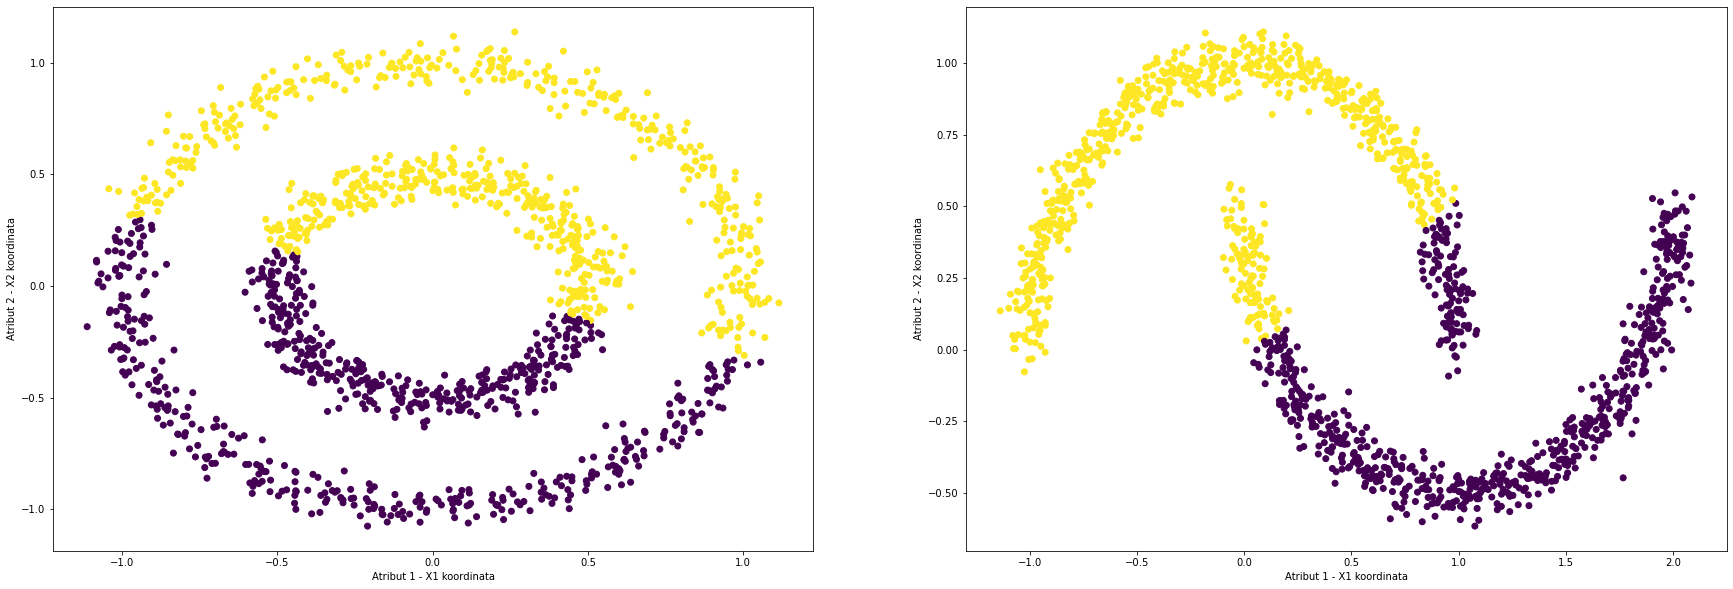

In [11]:
plt.figure(figsize=(30, 10)) # generiraj prazno sliko
plot_nr = 1 # inicializiraj števec za število slik

for key in datsets2: # za vsako podatkovno zbirko
    X, y = datsets2[key] # pridobi podatke
    scaler = StandardScaler() # standardiziraj podatke
    kmeans = KMeans(n_clusters=2,init='random',n_init=5,max_iter=200) # inicializiraj algoritem
    y_pred = kmeans.fit_predict(scaler.fit_transform(X)) # poženi algoritem
    # nariši
    plt.subplot(1, len(datsets2), plot_nr)
    plt.scatter(X[:, 0], X[:, 1], c=y_pred) 
    plt.xlabel('Atribut 1 - X1 koordinata')
    plt.ylabel('Atribut 2 - X2 koordinata')
    plot_nr += 1

V takih primerih se priporočajo drugi pristopi. Na primer, **DBSCAN (prostorsko gručenje aplikacij s šumom na podlagi gostote)** uporablja gostoto podatkovnih točk namesto njihovih razdalj, zato bi bil v tem primeru uspešnejši.

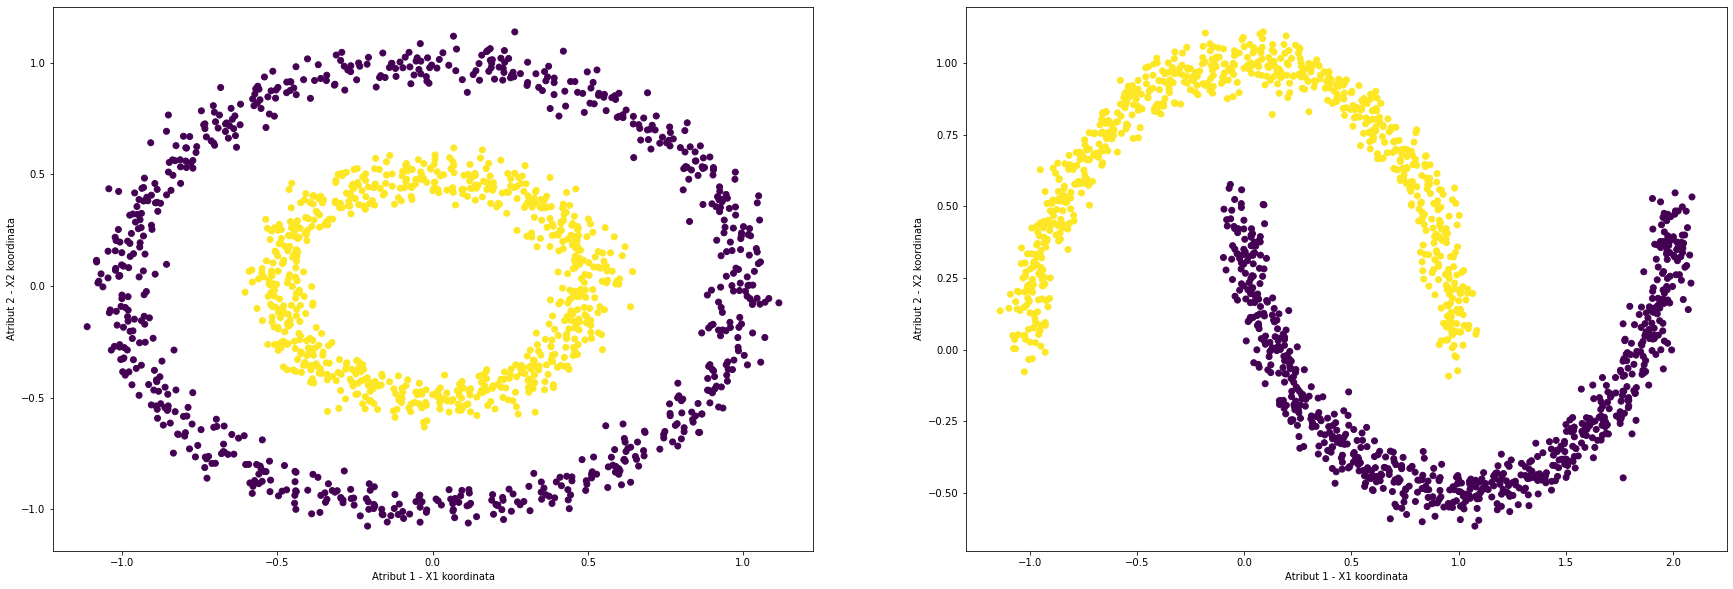

In [12]:
from sklearn.cluster import DBSCAN 

plt.figure(figsize=(30, 10)) # ustvari prazno sliko
plot_nr = 1 # inicializiraj števec za število slik

for key in datsets2: # za vsako podatkovno zbirko
    X, y = datsets2[key] # pridobi podatke
    scaler = StandardScaler() # standardiziraj podatke
    dbscan = DBSCAN(eps=0.3,min_samples=10) # inicializiraj algoritem
    y_pred = dbscan.fit_predict(scaler.fit_transform(X)) # poženi algoritem
    # nariši
    plt.subplot(1, len(datsets2), plot_nr)
    plt.scatter(X[:, 0], X[:, 1], c=y_pred) 
    plt.xlabel('Atribut 1 - X1 koordinata')
    plt.ylabel('Atribut 2 - X2 koordinata')
    plot_nr += 1

DBSCAN je uspešno prepoznal obe obliki, saj ga zanima gostota kot prikaz združevanja podatkov in ne njihova razdalja (kar je očitno, če primerjamo rezultate KMeans na istih podatkovnih nizih). Po drugi strani pa DBSCAN ne bo dobro deloval, če se gostota oblik spreminja.

Dva hiperparametra, ki smo ju določili za DBSCAN, sta:
* _eps_ je največja razdalja med dvema vzorcema, da se eden šteje za sosesko drugega.
* _min__samples_ je število vzorcev v soseščini, da se točka šteje za osrednjo točko.

Te hiperparametre je veliko težje nastaviti kot tiste pri KMeans, saj so bolj abstraktni, zato je ta algoritem, čeprav je močnejši od KMeans, bolj občutljiv in ga je težko pravilno nastaviti.

## 9.2. Primer uporabe KMeans za združevanje vremenskih postaj glede na podnebne značilnosti

V tem primeru bomo uporabili nabor podatkov meteoroloških (vremenskih) postaj v Kanadi, katerega značilnosti so meritve na vsaki postaji. Izvedli bomo gručenje glede na vrste podnebja, nato pa bomo postaje geografsko vizualizirali in ocenili naš pristop.

Potrebovali boste naslednje knjižnice:
1. wget -> (conda install -c conda-forge python-wget) za prenos datotek
2. cartopy -> (conda install -c conda-forge cartopy) za risanje zemljevida
3. PIL -> (conda install -c anaconda pillow)

Informacije o podatkovni zbirki:
<h4 align = "center">
Okolje v Kanadi   
Mesečne vrednosti za julij - 2015	
</h4>
<html>
<head>
<style>
table {
    font-family: arial, sans-serif;
    border-collapse: collapse;
    width: 100%;
}

td, th {
    border: 1px solid #dddddd;
    text-align: left;
    padding: 8px;
}

tr:nth-child(even) {
    background-color: #dddddd;
}
</style>
</head>
<body>

<table>
  <tr>
    <th>Ime v tabeli</th>
    <th>Pomen</th>
  </tr>
  <tr>
    <td><font color = "green"><strong>Stn_Name</font></td>
    <td><font color = "green"><strong>Ime postaje</font</td>
  </tr>
  <tr>
    <td><font color = "green"><strong>Lat</font></td>
    <td><font color = "green"><strong>Širina (Sever+, stopinje)</font></td>
  </tr>
  <tr>
    <td><font color = "green"><strong>Long</font></td>
    <td><font color = "green"><strong>Dolžina (Zahod - , stopinje)</font></td>
  </tr>
  <tr>
    <td>Prov</td>
    <td>Province</td>
  </tr>
  <tr>
    <td>Tm</td>
    <td>Povprečna temperatura (°C)</td>
  </tr>
  <tr>
    <td>DwTm</td>
    <td>Število brez povprečne temperatura</td>
  </tr>
  <tr>
    <td>D</td>
    <td>Mean Temperature difference from Normal (1981-2010) (°C)</td>
  </tr>
  <tr>
    <td><font color = "black">Tx</font></td>
    <td><font color = "black">Največja mesečna temperatura (°C)</font></td>
  </tr>
  <tr>
    <td>DwTx</td>
    <td>Število dni brez maksimalne temperature</td>
  </tr>
  <tr>
    <td><font color = "black">Tn</font></td>
    <td><font color = "black">Najnižja mesečna temperura (°C)</font></td>
  </tr>
  <tr>
    <td>DwTn</td>
    <td>Dnevi brez najnižje temperature</td>
  </tr>
  <tr>
    <td>S</td>
    <td>Sneg (cm)</td>
  </tr>
  <tr>
    <td>DwS</td>
    <td>Število dni brez snega</td>
  </tr>
  <tr>
    <td>S%N</td>
    <td>Odstotek normalnega (1981-2010) sneženja</td>
  </tr>
  <tr>
    <td><font color = "green"><strong>P</font></td>
    <td><font color = "green"><strong>Vse padavine (mm)</font></td>
  </tr>
  <tr>
    <td>DwP</td>
    <td>Število dni brez padavin</td>
  </tr>
  <tr>
    <td>P%N</td>
    <td>Odstotek normalnih (1981-2010) padavin</td>
  </tr>
  <tr>
    <td>S_G</td>
    <td>Sneg na tleh ob koncu meseca (cm)</td>
  </tr>
  <tr>
    <td>Pd</td>
    <td>Število dni s padavinami 1.0 mm ali več</td>
  </tr>
  <tr>
    <td>BS</td>
    <td>Sončni dnevi (hours)</td>
  </tr>
  <tr>
    <td>DwBS</td>
    <td>Dnevi brez sončnih dnevov</td>
  </tr>
  <tr>
    <td>BS%</td>
    <td>Odstotek normalnih(1981-2010) sončnih dni</td>
  </tr>
  <tr>
    <td>HDD</td>
    <td>Število dni pod 18 °C</td>
  </tr>
  <tr>
    <td>CDD</td>
    <td>Število dni nad 18 °C</td>
  </tr>
  <tr>
    <td>Stn_No</td>
    <td>Identifikator podnebne postaje (prve tri številke označujejo povodje, zadnji štirje znaki so namenjeni razvrščanju po abecedi).</td>
  </tr>
  <tr>
    <td>NA</td>
    <td>Ni na voljo</td>
  </tr>


</table>

</body>
</html>
    
Uvozite potrebne knjižnice, prenesite datoteko s podatki:

In [13]:
import wget
import cartopy.crs as ccrs
import cartopy

ModuleNotFoundError: No module named 'wget'

Če knjižnic **wget** in **cartopy** ni mogoče uvoziti, najprej odkomentirajte in zaženite naslednjo celico, nato pa ju poskusite znova uvoziti

In [ ]:
#!pip install wget
#!pip install cartopy

Nato vključite naslednje knjižnice

In [15]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
wget.download('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/weather-stations20140101-20141231.csv')

In [16]:
data = pd.read_csv('weather-stations20140101-20141231.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'weather-stations20140101-20141231.csv'

In [17]:
data.head()

NameError: name 'data' is not defined

Odstranite prazne podatke(NaN):

In [ ]:
data.drop(columns=['BS', 'DwBS', 'BS%', 'D', 'S', 'DwS', 'S%N', 'P%N', 'S_G'], inplace=True)
data.dropna(axis='rows', inplace=True)

In [ ]:
data.info()

In [ ]:
data.describe()

In [ ]:
coords = data[['Long', 'Lat']]

Odstranite vse stolpce, ki niso vezani na podnebje:

In [ ]:
data.drop(columns=['Long', 'Lat', 'Stn_No', 'Stn_Name', 'Prov'], inplace=True)
data.head()

Geografska porazdelitev podnebnih postaj:

In [ ]:
extent = [-140, -50, 40, 65]

plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
ax.set_extent(extent)
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAKES)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.BORDERS)
ax.scatter(coords['Long'], coords['Lat'], transform=ccrs.PlateCarree(), color='r', s=10)
plt.show()

KMeans gručenje

In [ ]:
max_nr_clusters = 10
cost_func = []
for nr_clusters in range(1, max_nr_clusters + 1):
    scaler = StandardScaler()
    kmeans = KMeans(n_clusters=nr_clusters, init='k-means++', n_init=20)
    kmeans.fit(scaler.fit_transform(data))
    cost_func.append(kmeans.inertia_)

plt.plot(range(1, max_nr_clusters + 1), cost_func)
plt.xlabel('number of clusters')
plt.ylabel('Distortion')
plt.xticks(range(1,  max_nr_clusters + 1))
plt.grid()

Glede na komolčno metodo, izbiramo med 3 or 6 gručami. Recimo, da izberemo 3. 

In [ ]:
scaler = StandardScaler()
kmeans = KMeans(n_clusters=3, init='k-means++', n_init=20)
y_pred = kmeans.fit_predict(scaler.fit_transform(data))

In [ ]:
extent = [-140, -50, 40, 65]

plt.figure(figsize=(14, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
ax.set_extent(extent)
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.OCEAN)
ax.add_feature(cartopy.feature.COASTLINE)
ax.add_feature(cartopy.feature.LAKES)
ax.add_feature(cartopy.feature.RIVERS)
ax.add_feature(cartopy.feature.BORDERS)
ax.scatter(coords['Long'], coords['Lat'], transform=ccrs.PlateCarree(), c=y_pred, s=10)
plt.show()

Če pri treh gručah zanemarimo postaje na severu Kanade, lahko vidimo, da združevanje v gruče glede na vremenske značilnosti dejansko ustvari gruče, ki so razporejeni glede na bližino postaje oceanu. 

To je sicer smiselno, vendar bi morda poskus združevanja v gruče s skrbno nastavljeno metodo DBSCAN prinesel boljše rezultate. 

Poskusite tudi z drugačnim številom gruč.

## 9.3. Uporaba gručenja

Gručenje KMeans je dokaj enostavno za uporabo tudi pri velikih podatkovnih nizih, zato ima veliko možnosti uporabe. Med drugim se je uspešno uporabljalo za gručenje uporabnikov pri segmentaciji trga, klasifikacijo astronomskih objektov in obdelavo slik v računalniškem vidu ter na številnih drugih področjih. Pogosto se uporablja tudi kot korak predhodne obdelave za druge algoritme.

Tukaj bomo prikazali uporabo gručenja KMeans za kvantizacijo barv. To je postopek zmanjšanja barvne palete slike na določeno število barv _k_. To storimo tako, da vsako piko slike vzamemo kot podatkovno točko, njene vrednosti RGB pa kot značilnosti. Nato piksle razdelimo v _k_ gruč z uporabo KMeans in vsakemu pikslu dodelimo novo barvo - barvo njegovega centroida gruče.

In [ ]:
# vključi knjižnice
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy.io import loadmat
from IPython.display import Image, display

display(Image(filename='bird_small.png')) # prikaži sliko
image_data = loadmat('bird_small.mat') # naloži RGB vrednosti piklov v sliki
A = image_data['A']
print ("Original pixel RGB values:\n",A)

A = A / 255. # normaliziraj
X = np.reshape(A, (A.shape[0] * A.shape[1], A.shape[2])) # spremeni tabelo

print ("Number of pixels (rows):",np.size(X,axis=0))
print ("Number of colors (columns) ",np.size(X,axis=1))
print ("Data:\n",X)

Zdaj imamo podatke v polju X, ki predstavljajo vse vrednosti slikovnih pik s številom med 0 in 1. Opazite, da je slikovnih pik 16384 (ločljivost), vsaka slikovna pika pa ima 3 barve (rdeči, zeleni in modri odtenek).

Nato uporabimo metodo KMeans, da piksle razdelimo v gruče glede na podobnost njihovih barv. Nato barvo vsakega piksla nadomestimo z barvo centroidov njegove gruče.

In [ ]:
n_clusters = 16 # definiraj število gruč

# Poženi algoritem
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=5) 
y_pred = kmeans.fit_predict(X)

# Spremeni vsak pikel z barvo centroida gruče in prikaži sliko
X_recovered = kmeans.cluster_centers_[y_pred] 
X_recovered = np.reshape(X_recovered, (A.shape[0], A.shape[1], A.shape[2]))
plt.imshow(X_recovered);

Slika ima zdaj toliko barv, kolikor je grozdov. Slika je še vedno prepoznavna, vendar vsebuje veliko manj barv kot izvirnik, njena velikost in pomnilniške zahteve pa so tako manjše.

Poskusite ponovno zbrati grozde in regenerirati sliko z različnim številom gruč.

In [ ]:
import session_info
session_info.show()